In [1]:
import numpy as np
import re
import random

import tensorflow as tf
import sklearn as sk

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model
from RNNModel import RNN_Model

# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
from gensim.models import Word2Vec

sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=50)
#model.save('W2V')

model = Word2Vec.load('W2V')
vocab = model.wv.vocab.keys()

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Sentence Load Complete


# Layer and Index Loading

In [5]:
#word_indices, emb_layer = fn.get_index_and_emb_layer(model)
#fn.write_word_indices(word_indices, 'word_indices')
#fn.write_emb_layer(emb_layer, 'emb_layer')

word_indices = fn.load_word_indices('word_indices')
emb_layer = fn.load_emb_layer('emb_layer')

Word Indices Load Complete
Embedding Layer Load Complete


# RNN Testing

In [10]:
train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing()
validation_cases.process_for_testing()
test_cases.process_for_testing()

In [18]:
lw, rw = 2, 2
sets = {}
sets['train_set'], sets['train_labels'] = train_cases.get_rnn_sets(word_indices, left_words=lw, right_words=rw)
sets['validation_set'], sets['validation_labels'] = validation_cases.get_rnn_sets(word_indices, left_words=lw, right_words=rw)
sets['test_set'], sets['test_labels'] = test_cases.get_rnn_sets(word_indices, left_words=lw, right_words=rw)

In [19]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set_training(sets['train_set'], sets['train_labels'], 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.03% non-med: 0.97%
Ratio: med: 0.11% non-med: 0.89%


C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


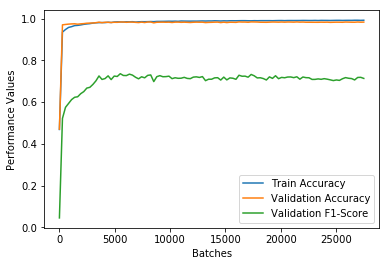

FInal Values: TrAcc: 0.992, ValAcc: 0.983, ValF1: 0.714
Test F1-Score: 0.732



In [20]:
RNN = RNN_Model(vocab_size=len(word_indices), state_size=100, num_classes=2, window=5, learn_rate=0.001, emb_layer=emb_layer)
RNN.build_graph()
_, _, _, _, = RNN.train(sets=sets, epochs=5, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [ ]:
res = sess.run([g['preds']], feed_dict={g['x']: sets['train_set'], g['y']: sets['train_labels'], g['seqlen']: np.ones(len(sets['test_set']))*7})
tru = np.argmax(sets['test_labels'], 1)

In [ ]:
TP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 0)])
TN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 1)])
FP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 1)])
FN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

In [ ]:
[(sets['test_words'][a], res[a], tru[a]) for a in range(len(sets['test_words'])) if res[a] == 0 and tru[a] == 1]

# HyperParameter Scan

In [ ]:
emb_sizes = [100]
emb_models = 1
target_saturations = [0.05, 0.1, 0.2, 0.5, 0.7]
layer_sizes = [50]
dropouts = [1.0]
learn_rates = [0.01]
epochs = [100]
NN_num = 5

case_num = len(emb_sizes)*emb_models*len(layer_sizes)*len(target_saturations)*len(epochs)*len(dropouts)*len(learn_rates)*NN_num
print(case_num)

In [ ]:
max_performance = 0
n = 1

for emb_size in emb_sizes:
    print('Model Number: %d/%d' %(n, case_num))
    for i in range(emb_models):
        model = Word2Vec(sentences, min_count=1, size=emb_size)
        for saturation in target_saturations:
            sets = fn.get_traintest2 (labelled_cases, model)
            fn.saturate_training_set(sets, model, target_dict['medications'], saturation)
            for layer_size in layer_sizes:
                for drop in dropouts:
                    for rate in learn_rates:
                        for epoch in epochs:
                            for j in range(NN_num):
                                print('Model Number: %d/%d' %(n, case_num))
                                print('ES: %d EM: %d sat: %f, LS: %d, drop: %f, LR: %f, epochs: %d, NN: %d' \
                                       % (emb_size, i, saturation, layer_size, drop, rate, epoch, j))
                                NN = FF_Model(input_size=emb_size, layers=[layer_size], dropout=drop, learn_rate=rate)
                                NN.build_graph()
                                NN.train(sets, epochs=epoch)
                                res = NN.predict(sets['test_set'])
                                tru = np.argmax(sets['test_labels'], 1)
                                perf = sk.metrics.f1_score(tru, res, pos_label=0)
                                if perf > max_performance:
                                    max_performance = perf
                                    NN.save_model('gold')
                                    model.save('gold/GOLDEMB')
                                NN.close()
                                n += 1